In [1]:
import numpy as np 
import tensorflow as tf
import os 
import sys 

import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
from matplotlib import cm

def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower', aspect="auto", 
                  norm=cm.colors.NoNorm(vmin=0,vmax=1), cmap=plt.get_cmap(cmap))

"""

input will be something like [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
return colors ['red', 'green', ...]

"""
def get_fnirs_channel_colors(ranked_channel):
    colors = []
    # asign color to channel 
    dpc_color = 'lightblue'
    stg_color = 'purple'
    vpc_color = (1.0, 0.5, 0.0)
    mpc_color = (1.0, 0.64, 0.0)
    psfc_color = 'green'

    # Posterior superior frontal cortex
    PSFC_ch = ['C9', 'C10', 'C20', 'C21', 'C1', 'C2', 'C11', 'C12'] # left_PSFC_location = ['C9', 'C10', 'C20', 'C21'] , right_PSFC_location = ['C1', 'C2', 'C11', 'C12']

    # Dorsolateral prefrontal cortex
    DPC_ch = ['C7','C8', 'C17', 'C18', 'C19', 'C28', 'C29', 'C3', 'C4', 'C13', 'C14', 'C15', 'C24', 'C25']# left_DPC_location = ['C7','C8', 'C17', 'C18', 'C19', 'C28', 'C29'], right_DPC_location = ['C3', 'C4', 'C13', 'C14', 'C15', 'C24', 'C25']

    #Superior temporal gyrus
    STG_ch = ['C22', 'C23', 'C32', 'C33', 'C43', 'C44', 'C30', 'C31', 'C41', 'C42', 'C51', 'C52'] #left_STG_location = ['C22', 'C23', 'C32', 'C33', 'C43', 'C44'], right_STG_location = ['C30', 'C31', 'C41', 'C42', 'C51', 'C52']

    # Ventrolateral prefrontal cortex
    VPC_ch = ['C34', 'C35', 'C45', 'C46','C39', 'C40', 'C49', 'C50'] # left_VPC_location = ['C34', 'C35', 'C45', 'C46'], right_VPC_location = ['C39', 'C40', 'C49', 'C50']

    # Medial prefrontal cortex
    MPC_location = ['C5', 'C6', 'C16', 'C26', 'C27', 'C36', 'C37', 'C38', 'C47', 'C48']  


    for ch in ranked_channel:
        ch_name = 'C' + str(ch+1) 
        if ch_name in PSFC_ch:
            colors.append(psfc_color)
        elif ch_name in DPC_ch:
            colors.append(dpc_color)
        elif ch_name in STG_ch:
            colors.append(stg_color)
        elif ch_name in VPC_ch:
            colors.append(vpc_color)
        elif ch_name in MPC_location:
            colors.append(mpc_color)
        else:
            print('ch not found', ch_name)
            colors.append('grey')
            
    return colors

def show_ranked_shap_channel_importance(data):
    
    # Calculate both mean and standard deviation along the specified axes
    channel_importance_mean = np.mean(data, axis=(0))
    channel_importance_std = np.std(data, axis=(0))

    # Ranking the channels by their importance (mean values)
    ranked_channel = np.argsort(channel_importance_mean) 
    ranked_channel = ranked_channel[::-1]
    print("Ranked channels by importance:", ranked_channel)

    # 
    ranked_channel_x = ['C' + str(i+1) for i in ranked_channel]
    ranked_channel_importance = channel_importance_mean[ranked_channel]
    ranked_channel_importance_std = channel_importance_std[ranked_channel]
    error = [np.zeros(channel_importance_std.shape), ranked_channel_importance_std]  # First row zeros, second row stds

    fig, ax = plt.subplots(figsize=(20,10))

    shap_bar = ax.bar(ranked_channel_x, ranked_channel_importance, yerr=error, capsize=5, edgecolor='grey')



    yticks = [0, 0.5, 1, 1.2]
    yticklabels = ['0', '0.5', '1', ' ']
    # yticks = [0, 1e-4, 2e-4, 3e-4]
    # yticklabels = ['0', '0.0001', '0.0002', '0.0003']
    plt.yticks(yticks, yticklabels,fontsize=20)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.get_offset_text().set_fontsize(15)

    # plt.ylim(0, 0.00025)  # Optional: Set y-axis limits if necessary

    plt.xticks(np.arange(52), fontsize=15, rotation=45, fontweight='bold')  # Optional: Improve x-axis readability if necessary
    plt.ylabel('mean |SHAP value|',fontsize=15, fontweight='bold')
    plt.xlabel('Ranked channel',fontsize=15, fontweight='bold')
    plt.title('Average Channel Importance', fontweight='bold', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

    gradientbars(shap_bar, ranked_channel_importance, 'viridis_r')


    # marker the region color of each channel
    colors = get_fnirs_channel_colors(ranked_channel)
    y_marker_position = 1.2 * 0.95
    for bar, color in zip(shap_bar, colors):
        # Calculate the center of the bar
        center_x = bar.get_x() + bar.get_width() / 2
        
        # Use scatter to add a colored square marker
        ax.scatter(center_x, y_marker_position, s=400, color=color, marker='s', zorder=3)

    plt.show()


def squeeze_abs_mean(data):
    data = np.squeeze(data)
    data = np.mean(np.abs(data), axis=2)
    return data


main_pth = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/'
sys.path.append(main_pth)
os.chdir(main_pth)




2024-04-19 08:10:22.436278: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 08:10:22.454947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 08:10:22.454965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 08:10:22.454972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 08:10:22.459240: I tensorflow/core/platform/cpu_feature_g

In [ ]:
i = 11
loo = np.load(f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v{i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap_val.npy',allow_pickle=True)

print(f'1 - loo shape: {loo.shape}')

In [10]:
loo[0].shape

(11, 52, 2500, 1, 2)

In [13]:
len(loocv)

6

In [ ]:
loocv = []

for i in range(5, 12):
    loo = np.load(f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v{i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap_val.npy',allow_pickle=True)
    loo = np.concatenate(loo, axis=0)
    print(f'1 - loo shape: {loo.shape}')
    loo = squeeze_abs_mean(loo)[..., 1] # average time dimension and take the predicton - 1 value
    print(f'2 - loo shape: {loo.shape}')
    loo = np.mean(loo, axis=0) #[np.newaxis, ...]
    print(f'3 - loo shape: {loo.shape}')
    loocv.append(loo)
    



In [17]:
import os

for i in range(4, 14):
    for file_name in ['shap', 'shap_val', 'shap_test']:
        file_path = f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v{i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/{file_name}.npy'
        if os.path.exists(file_path):
            os.remove(file_path)
        

Ranked channels by importance: [30 10 41 19 31 51  9 40 32 21 20 44  8 29 43  2 11 47  0 22 39  7  1  3
 12 42  4 50 33 13  6 14 48 37 18 15 36 49 34 38 16  5 35 46 23 17 24 28
 45 27 26 25]


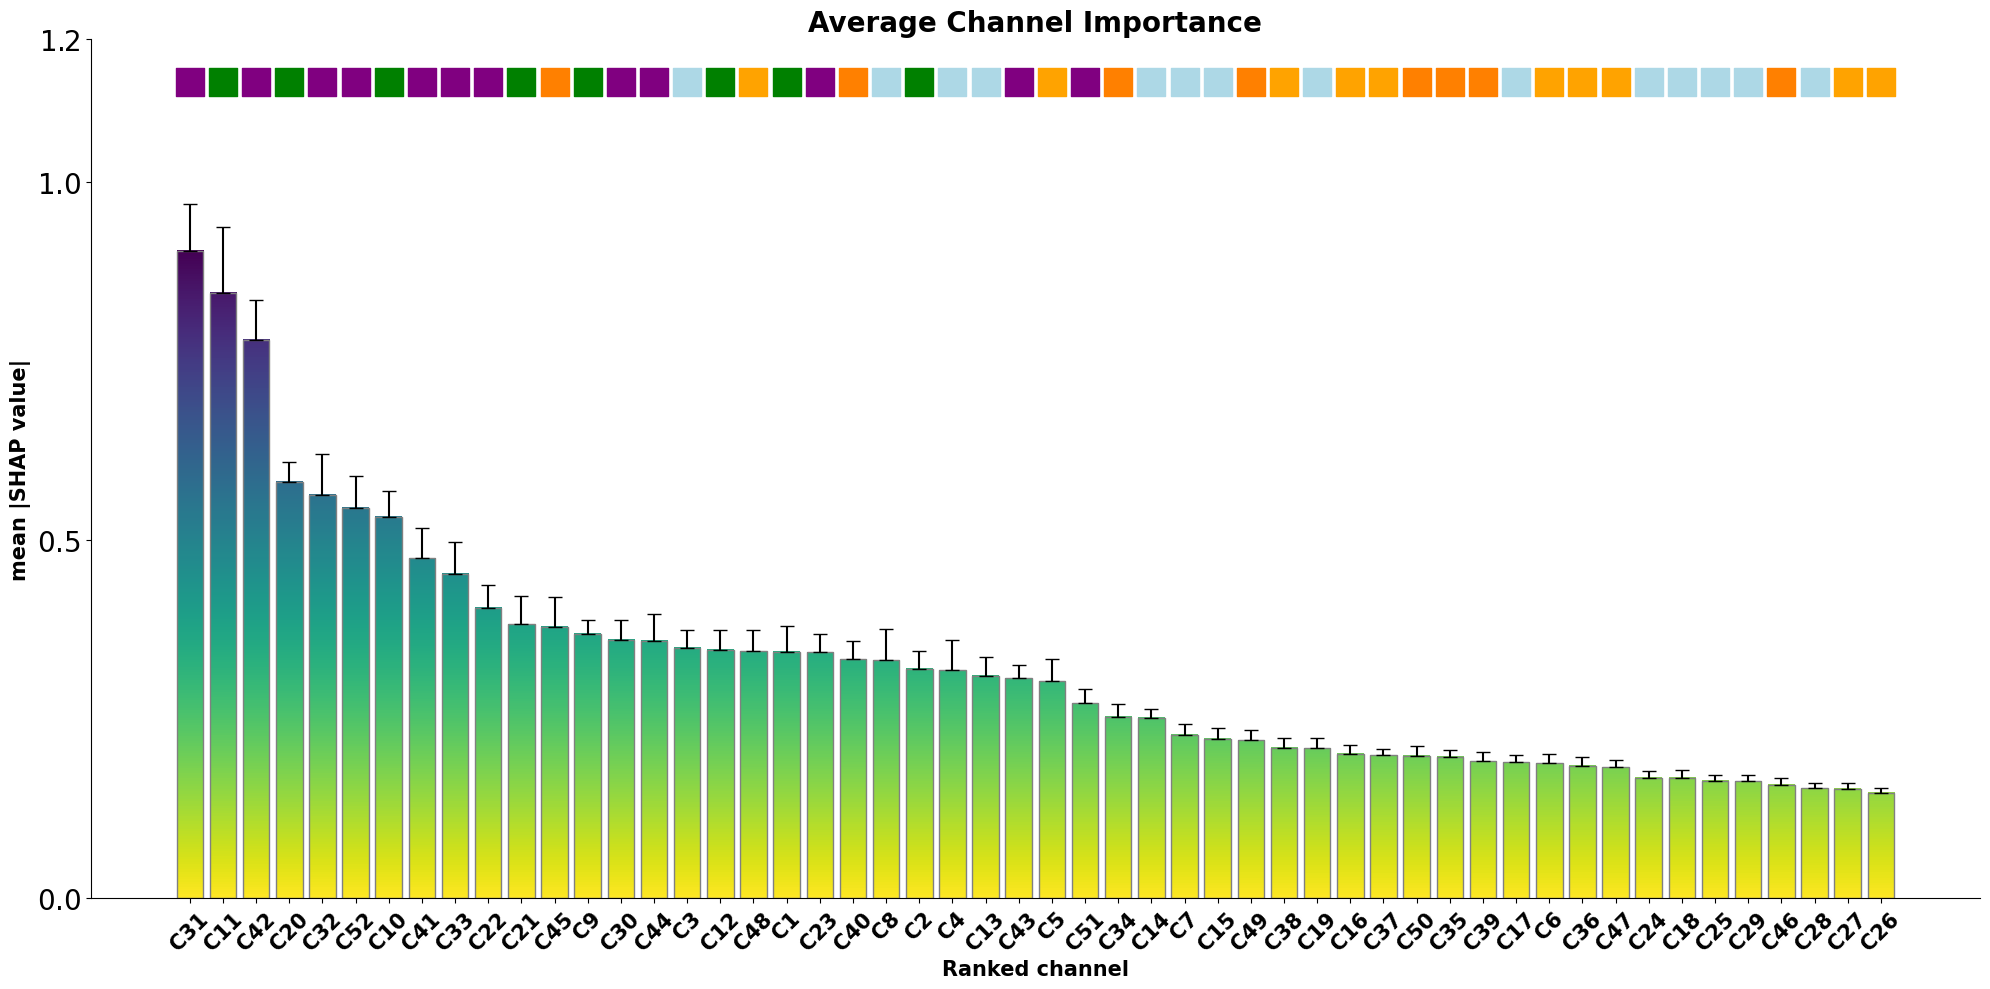

In [21]:
loocv = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten_itr_shap.npy')
loocv = np.array(loocv)
loocv = loocv / np.max(loocv)
show_ranked_shap_channel_importance(loocv)

In [12]:
np.save('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten_itr_shap', loocv)

In [2]:
loocv1 = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy')
loocv2 = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v2l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy')
loocv4 = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy')

loocv1.shape

(320, 1, 52, 2500, 1, 2)

In [3]:

def squeeze_abs_mean(data):
    data = np.squeeze(data)
    data = np.mean(np.abs(data), axis=2)
    return data

loocv1 = squeeze_abs_mean(loocv1)[..., 1]
loocv2 = squeeze_abs_mean(loocv2)[..., 1]
loocv4 = squeeze_abs_mean(loocv4)[..., 1]

loocv1.shape

(320, 52)

In [1]:
import matplotlib.pyplot as plt
def show_shap_channel_importance(data, title):
    
    
    # Calculate both mean and standard deviation along the specified axes
    channel_importance_mean = np.mean(data, axis=(0))
    channel_importance_std = np.std(data, axis=(0))
    error = [np.zeros(channel_importance_std.shape), channel_importance_std]  # First row zeros, second row stds
    # Plotting
    plt.figure(figsize=(15, 10))
    # np.arange(1, 53) is the x-values, channel_importance_mean is the height of the bars, and
    # channel_importance_std is used for the error bars (yerr parameter)
    plt.bar(np.arange(1, 53), channel_importance_mean, yerr=error, capsize=5)
    # plt.bar(np.arange(1, 53), channel_importance_mean, capsize=5)

    plt.xlabel('Channel')
    plt.ylabel('Importance')
    plt.title('Channel Importance '+ title)
    plt.ylim(0, 0.00025)  # Optional: Set y-axis limits if necessary
    plt.xticks(np.arange(1, 53))  # Optional: Improve x-axis readability if necessary
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

    # Ranking the channels by their importance (mean values)
    ranked_channel = np.argsort(channel_importance_mean) + 1
    ranked_channel = ranked_channel[::-1][:10]
    print("Ranked channels by importance:", ranked_channel)

    # Show plot
    plt.show()
    
    

In [ ]:
show_shap_channel_importance(loocv1, 'loocv1')
show_shap_channel_importance(loocv2, 'loocv2')
show_shap_channel_importance(loocv4, 'loocv4')

In [10]:
mean_loocv_1 = np.mean(loocv1, axis=0)[np.newaxis, ...]
mean_loocv_2 = np.mean(loocv2, axis=0)[np.newaxis, ...]
mean_loocv_3 = np.mean(loocv4, axis=0)[np.newaxis, ...]

(1, 52)


Ranked channels by importance: [11 31 42 20 32 10 52 33 41 22]


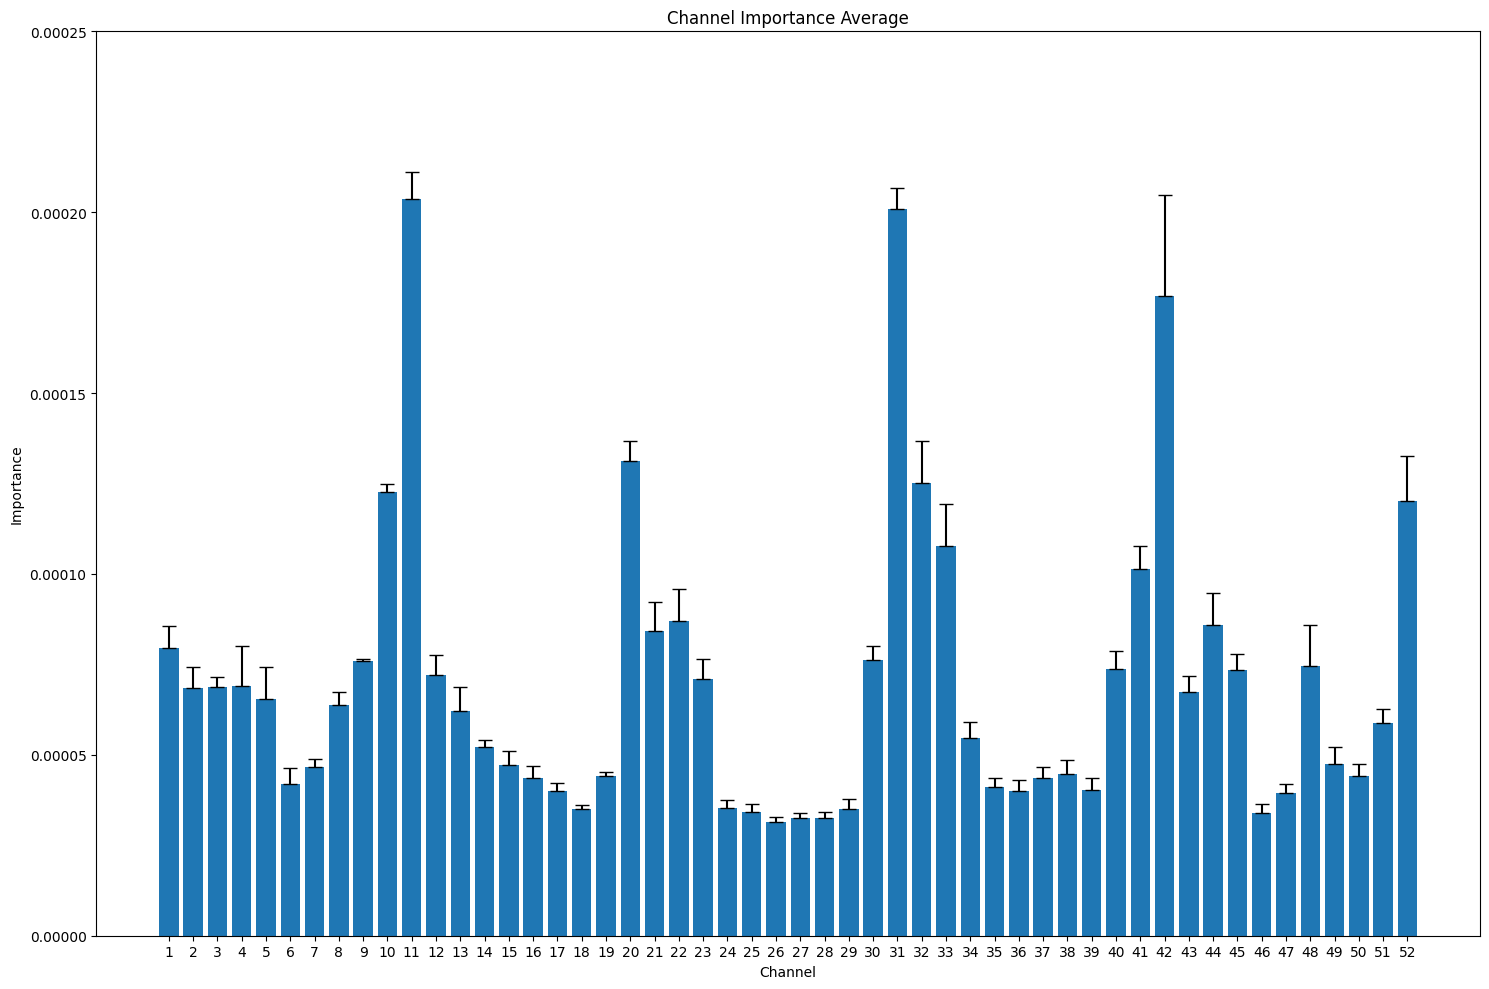

In [69]:
loocv = np.concatenate([mean_loocv_1, mean_loocv_2, mean_loocv_3], axis=0)
show_shap_channel_importance(loocv, 'Average')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Gradient Color Bar Plots
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path
from matplotlib.ticker import ScalarFormatter

def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower', aspect="auto", 
                  norm=cm.colors.NoNorm(vmin=0,vmax=1), cmap=plt.get_cmap(cmap))
fig, ax = plt.subplots(figsize=(20,10))
my_bar = ax.bar([channel_name_52[i][0] for i in channel_rank], [mean_hc_mdd[i] for i in channel_rank], color='red', edgecolor='black')
yticks = [0, 4e-4, 8e-4]
yticklabels = ['0', '0.0004', '0.0008']
plt.yticks(yticks, yticklabels,fontsize=20)
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))



plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.get_offset_text().set_fontsize(15)
plt.xticks(fontsize=15, rotation=45, fontweight='bold')
plt.ylabel('mean |SHAP value|',fontsize=15, fontweight='bold')
gradientbars(my_bar, [mean_hc_mdd[i] for i in channel_rank], 'viridis_r')
plt.show()


Ranked channels by importance: [30 10 41 19 31 51  9 40 32 21 20 44  8 29 43  2 11 47  0 22 39  7  1  3
 12 42  4 50 33 13  6 14 48 37 18 15 36 49 34 38 16  5 35 46 23 17 24 28
 45 27 26 25]


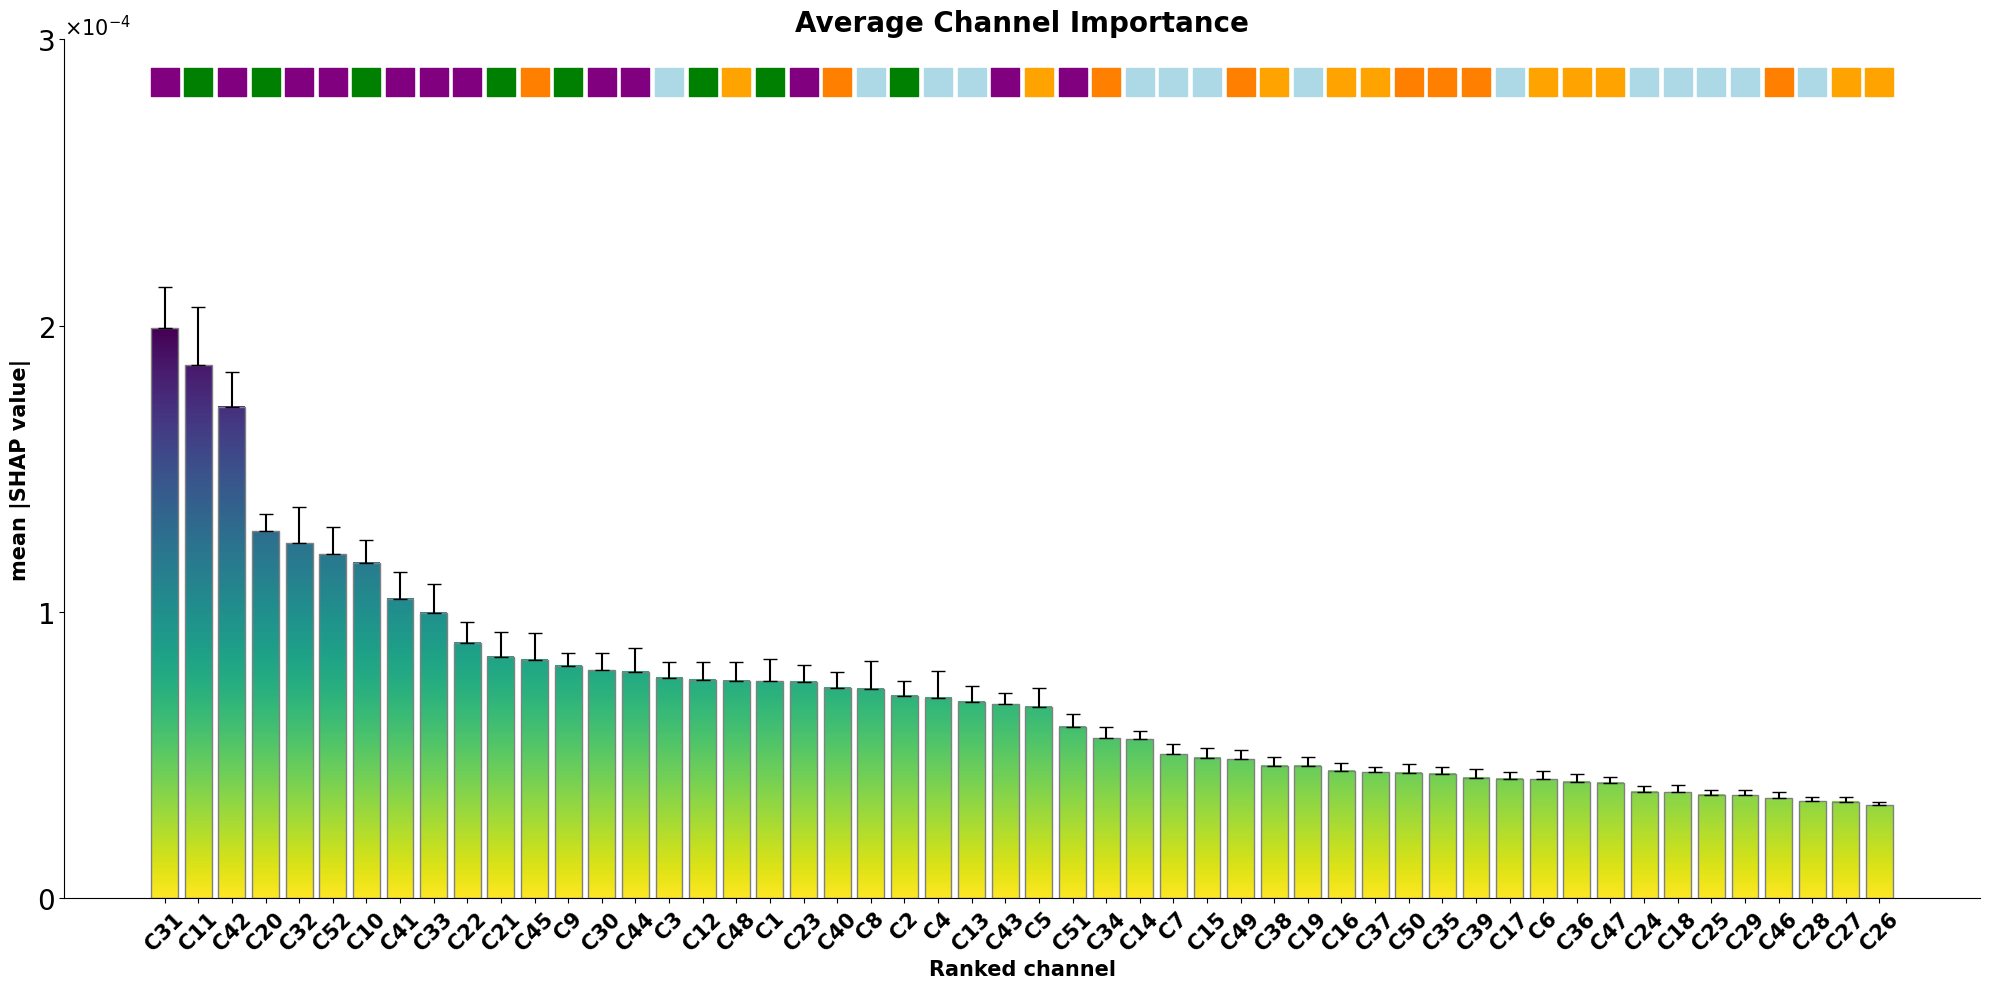

In [8]:
loocv.shape

(10, 52)

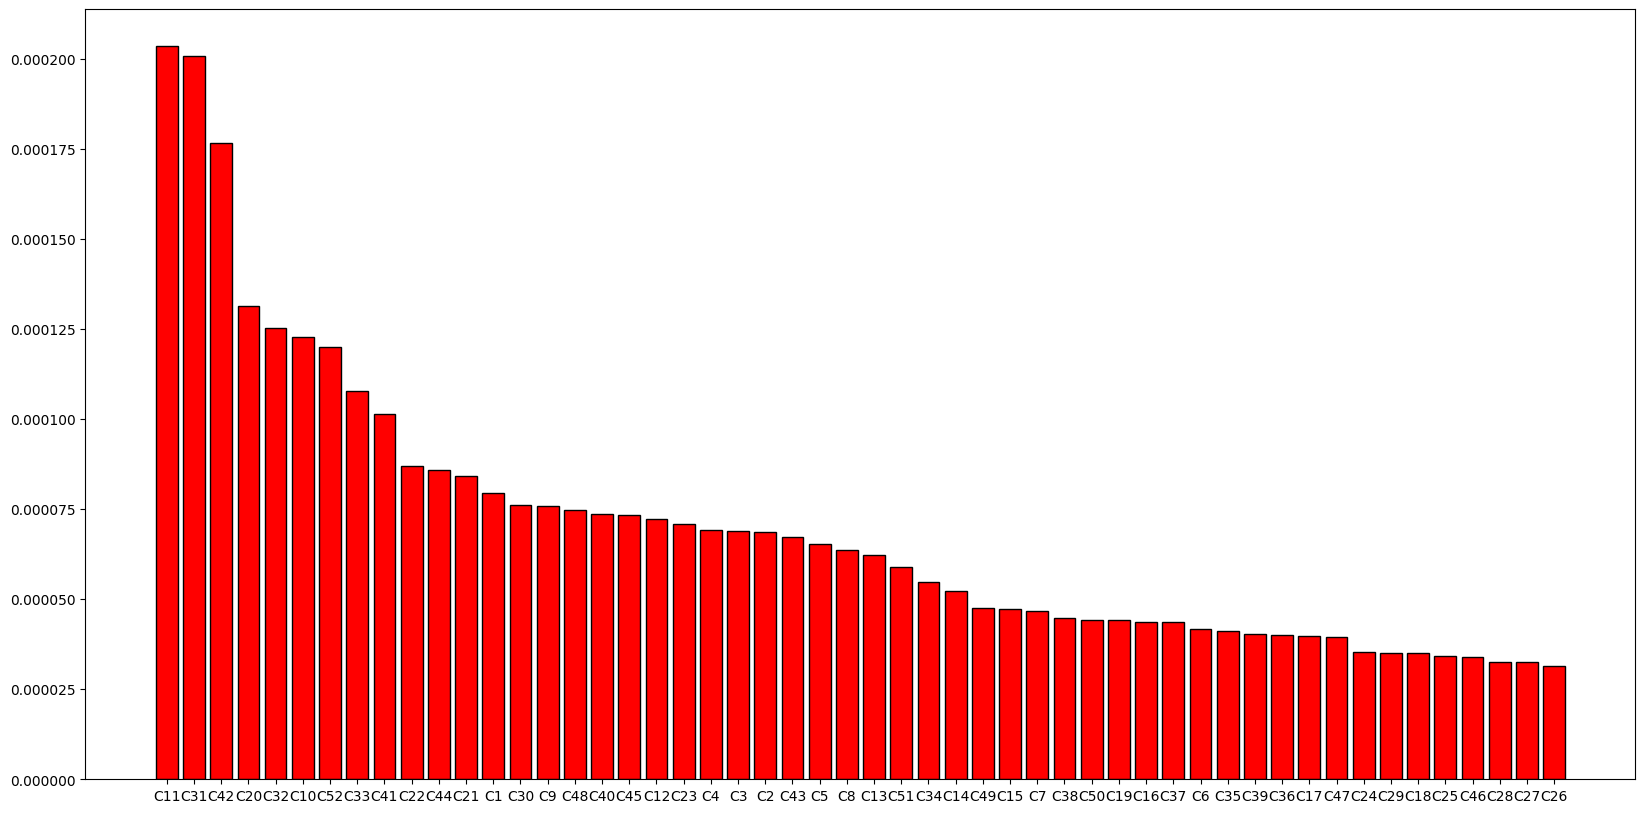

In [18]:
channel_importance_mean[ranked_channel]

fig, ax = plt.subplots(figsize=(20,10))

my_bar = ax.bar([f'C{i+1}'  for i in ranked_channel], channel_importance_mean[ranked_channel], color='red', edgecolor='black')